## Gather Character Data from .ttf Files

In [1]:
from PIL import Image, ImageDraw, ImageFont
import os, sys, shutil
from pathlib import Path
import glob

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import tensorflow
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import initializers

In [4]:
#constants
width, height = (224, 224)
random_dim = 100
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#character set dictionary
#limited to uppercase, lowercase and digits only
charset = {
    'Aa': 'A',
    'Bb': 'B',
    'Cc': 'C',
    'Dd': 'D',
    'Ee': 'E',
    'Ff': 'F',
    'Gg': 'G',
    'Hh': 'H',
    "Ii": 'I',
    'Jj': 'J',
    'Kk': 'K',
    'Ll': 'L',
    'Mm': 'M',
    'Nn': 'N',
    'Oo': 'O',
    'Pp': 'P',
    'Qq': 'Q',
    'Rr': 'R',
    'Ss': 'S',
    'Tt': 'T',
    'Uu': 'U',
    'Vv': 'V',
    'Ww': 'W',
    'Xx': 'X',
    'Yy': 'Y',
    'Zz': 'Z',
    'a': 'a',
    'b': 'b',
    'c': 'c',
    'd': 'd',
    'e': 'e',
    'f': 'f',
    'g': 'g',
    'h': 'h',
    'i': 'i',
    'j': 'j',
    'k': 'k',
    'l': 'l',
    'm': 'm',
    'n': 'n',
    'o': 'o',
    'p': 'p',
    'q': 'q',
    'r': 'r',
    's': 's',
    't': 't',
    'u': 'u',
    'v': 'v',
    'w': 'w',
    'x': 'x',
    'y': 'y',
    'z': 'z',
    '0': '0',
    '1': '1',
    '2': '2',
    '3': '3',
    '4': '4',
    '5': '5',
    '6': '6',
    '7': '7',
    '8': '8',
    '9': '9'
}

In [5]:
#loop
for filepath in glob.glob('fonts/**/*.ttf', recursive=True):
    path = filepath
    dirname = Path(filepath).stem
    os.mkdir('data/{}'.format(dirname))
    fontname = path.split('/')[-1]
    font = ImageFont.truetype(fontname, 224, encoding='utf-8')
    
    for c in charset:
        image = Image.new("RGB", (width, height), "black")
        draw = ImageDraw.Draw(image)
        offset_w, offset_h = font.getoffset(charset[c])
        w, h = draw.textsize(charset[c], font=font)
        pos = ((width-w-offset_w)/2, (height-h-offset_h)/2)
    
        #draw and save
        draw.text(pos, charset[c], "white", font=font)
        image.save("data/{}/{}.png".format(dirname, c))

***Note for Paolo:*** So far this includes just fonts with names beginning with 'A' - 'E' total 1269 fonts. Rough estimate puts the entire set at around 6,200 fonts. With each at 62 characters (uppercase, lowercase and 10 digits) that's roughly 385K images.

## Organize the Dataset

In [6]:
#make a folder for each class
folder='classes/'
classes=charset.keys()

for c in classes:
    os.mkdir('classes/{}'.format(c))

#loop through each font folder and each image in the folder
for filepath in glob.glob('data/**/*.png', recursive=True):
    path = filepath
    classname = Path(filepath).stem
    fontname = path.split('/')[1]
    filename = fontname + '_' + path.split('/')[-1]

    #move to class folder based on the filename
    shutil.move(path, 'classes/{}/{}'.format(classname, filename))

In [7]:
#inspect the class order
class_folders = os.listdir(folder)
class_folders.remove('.DS_Store')
class_folders

['Uu',
 'Yy',
 'Pp',
 'Bb',
 'Nn',
 'Gg',
 'Kk',
 'Ii',
 'Ee',
 'Ll',
 'r',
 'u',
 '9',
 '0',
 '7',
 'Rr',
 'i',
 'n',
 'g',
 '6',
 'z',
 '1',
 '8',
 't',
 's',
 'a',
 'f',
 'o',
 'h',
 'Ww',
 'Ss',
 'Vv',
 'Zz',
 'Dd',
 'Hh',
 'Aa',
 'Mm',
 'Oo',
 'Cc',
 'Jj',
 'Ff',
 'm',
 'j',
 'c',
 'Xx',
 'Tt',
 'd',
 'v',
 'q',
 '4',
 'x',
 '3',
 'e',
 'b',
 'k',
 'l',
 '2',
 'y',
 '5',
 'p',
 'Qq',
 'w']

## Process The Dataset

In [8]:
#create generator
datagen = ImageDataGenerator(rescale=1/255)

#prepare iterator for the dataset
batch_iter = datagen.flow_from_directory('classes/', class_mode='categorical', color_mode='grayscale', batch_size=32, target_size=(56, 56), classes=class_folders)

#confirm the iterator works
batch_X, batch_y = batch_iter.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batch_X.shape, batch_X.min(), batch_X.max()))

Found 78678 images belonging to 62 classes.
Batch shape=(32, 56, 56, 1), min=0.000, max=1.000


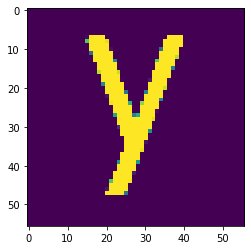

In [18]:
#Take a look at the data
test_image = batch_X[24]
plt.imshow(test_image)
plt.show()

In [19]:
#Ensure the class lines up
y_index = list(batch_y[24]).index(1)
print('The above image is from class: {}'.format(class_folders[y_index]))

The above image is from class: y


In [20]:
batch_X.shape

(32, 56, 56, 1)

In [21]:
batch_X = batch_X.reshape(32, 3136)
batch_X.shape

(32, 3136)

## Playing with the Dataset

### Constructor Functions

In [22]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(1004, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(2008))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(4016))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(3136, activation='tanh'))
    generator.compile(optimizer='adam', loss='binary_crossentropy')
    return generator

In [23]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(4016, input_dim=3136, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(2008))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1004))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(optimizer='adam', loss='binary_crossentropy')
    return discriminator

In [24]:
def create_gan(discriminator, random_dim, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(random_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    return gan

In [25]:
#output char images every epoch
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(15, 15)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 56, 56)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_chars_epoch_%d.png' % epoch)

In [26]:
def train(epochs=1, batch_size=32):
    batch_count = batch_X.shape[0]
    
    #build GAN network
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, random_dim, generator)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            #get random set of noise
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = batch_X[np.random.randint(0, batch_X.shape[0], size=batch_size)]
            
            #generate fake chars
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
            
            #labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            
            #train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            #train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
            
        #plot output every 10 epochs    
        if e == 1 or e % 50 == 0:
            plot_generated_images(e, generator)

In [ ]:
#test
train(500, 2450)

  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 11 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 13 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 14 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 15 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 16 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 17 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 18 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 19 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 20 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 21 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 22 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 23 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 24 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 25 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 26 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 27 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 28 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 29 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 30 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 31 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 32 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 33 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 34 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 35 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 36 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 37 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 38 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 39 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 40 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 41 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 42 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 43 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 44 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 45 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 46 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 47 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 48 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 49 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 50 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 51 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 52 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 53 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 54 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 55 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 56 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 57 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 58 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 59 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 60 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 61 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 62 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 63 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 64 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 65 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 66 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 67 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 68 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 69 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 70 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 71 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 72 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 73 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 74 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 75 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 76 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 77 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 78 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 79 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 80 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 81 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 82 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 83 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 84 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 85 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 86 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 87 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 88 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 89 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 90 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 91 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 92 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 93 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 94 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 95 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 96 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 97 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 98 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 99 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 100 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 101 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 102 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 103 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 104 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 105 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 106 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 107 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 108 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 109 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 110 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 111 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 112 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 113 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 114 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 115 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 116 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 117 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 118 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 119 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 120 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 121 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 122 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 123 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 124 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 125 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 126 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 127 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 128 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 129 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 130 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 131 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 132 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 133 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 134 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 135 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 136 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 137 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 138 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 139 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 140 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 141 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 142 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 143 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 144 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 145 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 146 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 147 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 148 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 149 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 150 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 151 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 152 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 153 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 154 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 155 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 156 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 157 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 158 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 159 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 160 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 161 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 162 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 163 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 164 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 165 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 166 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 167 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 168 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 169 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 170 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 171 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 172 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 173 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 174 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 175 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 176 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 177 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 178 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 179 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 180 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 181 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 182 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 183 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 184 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 185 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 186 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 187 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 188 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 189 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 190 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 191 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 192 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 193 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 194 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 195 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 196 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 197 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 198 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 199 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 200 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 201 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 202 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 203 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 204 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 205 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 206 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 207 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 208 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 209 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 210 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 211 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 212 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 213 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 214 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 215 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 216 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 217 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 218 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 219 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 220 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 221 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 222 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 223 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 224 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 225 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 226 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 227 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 228 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 229 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 230 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 231 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 232 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 233 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 234 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 235 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 236 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 237 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 238 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 239 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 240 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 241 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 242 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 243 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 244 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 245 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 246 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 247 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 248 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 249 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 250 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 251 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 252 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 253 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 254 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 255 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 256 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 257 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 258 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 259 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 260 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 261 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 262 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 263 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 264 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 265 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 266 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 267 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 268 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 269 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 270 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 271 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 272 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 273 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 274 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 275 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 276 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 277 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 278 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 279 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 280 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 281 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 282 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 283 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 284 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 285 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 286 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 287 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 288 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 289 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 290 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 291 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 292 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 293 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 294 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 295 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 296 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 297 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 298 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 299 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 300 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 301 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 302 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 303 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 304 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 305 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 306 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 307 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 308 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 309 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 310 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 311 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 312 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 313 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 314 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 315 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 316 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 317 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 318 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 319 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 320 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 321 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 322 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 323 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 324 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 325 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 326 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 327 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 328 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 329 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 330 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 331 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 332 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 333 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 334 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 335 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 336 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 337 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 338 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 339 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 340 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 341 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 342 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 343 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 344 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 345 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 346 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 347 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 348 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 349 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 350 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 351 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 352 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 353 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 354 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 355 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 356 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 357 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 358 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 359 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 360 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 361 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 362 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 363 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 364 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 365 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 366 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 367 ---------------


  0%|          | 0/32 [00:00<?, ?it/s]

--------------- Epoch 368 ---------------


 22%|██▏       | 7/32 [01:56<08:18, 19.93s/it]